In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
!unzip '/content/drive/MyDrive/archive.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/images_before_edit/x8ks9b.png  
  inflating: /content/images_before_edit/x8lfte.png  
  inflating: /content/images_before_edit/x8lo5v.png  
  inflating: /content/images_before_edit/x8mbla.png  
  inflating: /content/images_before_edit/x8mhgu.png  
  inflating: /content/images_before_edit/x8npp4.png  
  inflating: /content/images_before_edit/x8nr09.png  
  inflating: /content/images_before_edit/x8om0s.png  
  inflating: /content/images_before_edit/x8ozhu.png  
  inflating: /content/images_before_edit/x8rhav.png  
  inflating: /content/images_before_edit/x8tg8v.png  
  inflating: /content/images_before_edit/x8txfm.png  
  inflating: /content/images_before_edit/x8vzvu.png  
  inflating: /content/images_before_edit/x8w2i6.png  
  inflating: /content/images_before_edit/x8yg0l.png  
  inflating: /content/images_before_edit/x8z0gt.png  
  inflating: /content/images_before_edit/x9015n.png  
  inflating: /content/images_be

In [57]:
import os
from pathlib import Path
from google.colab.patches import cv2_imshow

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Augmentation

In [ ]:
## зоготовки функцій



## Loading the data

In [58]:
data_dir = Path('/content/images_before_edit/')

In [59]:
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

In [60]:
print(images[0])
print(labels[0])

/content/images_before_edit/000s72.png
000s72


In [61]:
len(images) == len(labels)

True

In [62]:
BATCH_SIZE = 64
IMG_WIDTH = 200
IMG_HEIGHT = 50

In [63]:
digits = sorted(characters)[:10]
letters = sorted(characters)[10:]

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))

Number of images found:  64961
Number of labels found:  64961
Number of unique characters:  36


Coder and encoder for labels

In [46]:
# converting a characters into number 
char_to_num = keras.layers.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None)


# converting vice versa
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), num_oov_indices=0,  mask_token=None, invert=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Split the data

In [64]:
def split_data(images, labels, tran_size=0.8, shuffle=True):

    size = len(images)
    np.random.seed(123)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
        
    samples_80 = int(len(images) * tran_size)
    samples_90 = int(len(images) * (tran_size + (1 - tran_size) / 2))

    #x_train, y_train = images[:samples_80], labels[:samples_80]
    #x_valid, y_valid = images[samples_80:samples_90], labels[samples_80:samples_90]
    #x_test, y_test = images[samples_90:], labels[samples_90:]

    x_train, y_train = images[indices[:samples_80]], labels[indices[:samples_80]]
    x_valid, y_valid = images[indices[samples_80:samples_90]], labels[indices[samples_80:samples_90]]
    x_test, y_test = images[indices[samples_90:]], labels[indices[samples_90:]]

    return x_train, x_valid, x_test, y_train, y_valid, y_test

Form dataset

In [65]:
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))

x_train[0], y_train[0]

('/content/images_before_edit/c4ibla.png', 'c4ibla')

In [66]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [67]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)

    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, perm=[1, 0, 2])

    # img /= 255.0 --> normalization

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}

Loading datasets

In [68]:
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(8) # buffer_size=tf.data.AUTOTUNE
)

validation_dataset  = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(8) # buffer_size=tf.data.AUTOTUNE
)

test_dataset  = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(8) # buffer_size=tf.data.AUTOTUNE
)


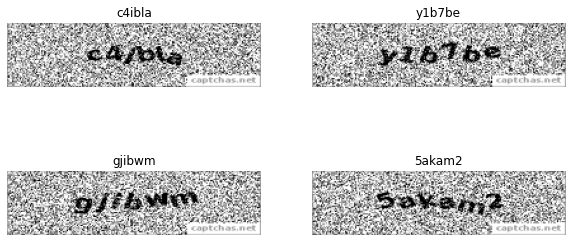

In [69]:
_, ax = plt.subplots(2, 2, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(4):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 2, i % 2].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 2, i % 2].set_title(label)
        ax[i // 2, i % 2].axis("off")
plt.show()

## Data changing

In [ ]:
import cv2
def remove_noise(img_file):
  kernel = np.ones((2,2), np.uint8)
  closing = cv2.morphologyEx(
      cv2.imread(img_file, cv2.IMREAD_UNCHANGED),
      cv2.MORPH_CLOSE,
      kernel)
  opening = cv2.morphologyEx(
      closing,
      cv2.MORPH_OPEN,
      kernel)
  dilation = cv2.dilate(
      opening,
      kernel)
  closing = cv2.morphologyEx(dilation,
                             cv2.MORPH_CLOSE,
                             kernel)
  erode = cv2.erode(closing, kernel)
  return erode

In [ ]:
from PIL import Image
for i in range(len(x_train)):
  Image.fromarray(remove_noise(x_train[i])).save(f'/content/drive/MyDrive/images_after_edit/{y_train[i]}.png')

In [ ]:
len(x_train) 

51968

In [ ]:
data_dir_train = Path('/content/drive/MyDrive/images_after_edit/')
train_images = list(map(str, list(data_dir_train.glob("*.png"))))
train_labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in train_images]


In [ ]:
train_x, train_y = np.array(train_images), np.array(train_labels)
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))

In [ ]:
train_data = (
    train_data.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(8)
)

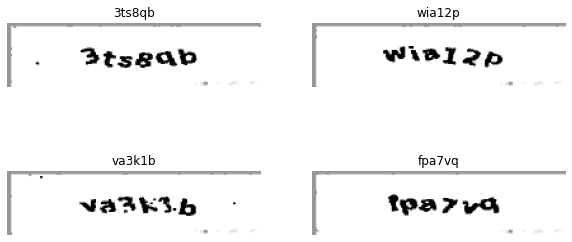

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(10, 5))
for batch in train_data.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(4):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 2, i % 2].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 2, i % 2].set_title(label)
        ax[i // 2, i % 2].axis("off")
plt.show()

# Bulding an OCR model (CRNN)

In [70]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    input_img = keras.layers.Input(
        shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32"
    )
    labels = keras.layers.Input(name="label", shape=(None,), dtype="float32")

    # 1 Conv2D()
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # 2 Conv2D()
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )

    opt = keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=opt)  #metrics=tf.keras.metrics.Accuracy()

    return model

In [71]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

## Trained model 2

In [74]:
# model = build_model()
weights = '/content/weights-improvement-82-0.30.hdf5'
model.load_weights(weights)

ValueError: ignored

In [ ]:
loss = model.evaluate(test_dataset)

In [22]:
max_length = 6

In [23]:
loss = trained_model_2.evaluate(test_dataset)
print(loss)

102/102 [==============================] - 45s 406ms/step - loss: 23.8279
23.827903747558594


In [28]:
# SAVED_MODEL = keras.models.Model(
#     model.get_layer(name="image").input, model.get_layer(name="dense2").output
# )

In [29]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [30]:
preds = trained_model_2.predict(test_dataset)
pred_texts = decode_batch_predictions(preds)

In [31]:
print(pred_texts[:2], y_test[:2])

['', ''] ['899tg0' 'wkr9u0']


In [ ]:
# def decode_batch_predictions(pred):
#     input_len = np.ones(pred.shape[0]) * pred.shape[1]
#     # Use greedy search. For complex tasks, you can use beam search
#     results = keras.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,:Max_Length]
#     # Iterate over the results and get back the text
#     output_text = []
#     for res in results:
#         res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
#         output_text.append(res)
#     return output_text

# #  Check results on some validation samples
# for batch in validation_dataset.take(1):
#     batch_images = batch['image']
#     batch_labels = batch['label']

#     preds = trained_model_2.predict(batch_images)
#     pred_texts = decode_batch_predictions(preds)

#     orig_texts = []
#     for label in batch_labels:
#         label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
#         orig_texts.append(label)

#     _, ax = plt.subplots( 8, 4, figsize=(10,12) )
#     for i in range(len(pred_texts)):
#         img = ( batch_images[i, :, :, 0]*255).numpy().astype(np.uint8)
#         img = img.T
#         title = f'Prediction: {pred_texts[i]}'
#         ax[i // 4, i % 4].imshow( img, cmap='gray' )
#         ax[i // 4, i % 4].set_title(title)
#         ax[i // 4, i % 4].axis("off")
# plt.show()

## Evaluation

Edit distance 

In [ ]:
edit_distance(pred_texts, y_test)

49

In [ ]:
for batch in test_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    #preds = model.predict(test_dataset)
    loss, accuracy = trained_model_2.evaluate(test_dataset)

 32/102 [========>.....................] - ETA: 27s - loss: 23.8172

KeyboardInterrupt: ignored

In [ ]:
print(f"accuracy: {accuracy * 100:.2f}%")

NameError: ignored

In [ ]:
#метрики - декодувати матрицю в стрінгу
#edit_distance враховувати в оцінці модельки